# Intro

Scenario: We were tasked with coming up with the salary of the next Syracuse Football coach. To do so, we were given a list of Schools and their Coache's salary. While this could be enough information to do a simple analysis, we will find more online resources to add information to our prediction. This includes finding the stadium sizes, the school's record, and the graduation rate.

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Path

In [ ]:
pwd

'/content'

In [ ]:
path = '' # Do not need a path for Colab

# Read Data

The file Coaches9.csv was provided for us. There is a limited amount of information in this file. The prediction column is 'TotalPay' while the other columns are not very helpful since they cant be used to predict the salary since they are part of the salary. On the other hand, the Conference column will be helpful to classify and visualize the data.

In [ ]:
df = pd.read_csv(path + 'Coaches9.csv')

In [ ]:
df.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500"
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417"


# Convert Money to Float

In [ ]:
df.describe()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
count,129,129,129,129,129,129,129,129,129
unique,129,11,129,104,105,85,51,1,102
top,Old Dominion,C-USA,Charlie Strong,"$3,500,000","$3,500,000",--,--,$0,--
freq,1,14,1,5,5,22,41,129,22


In [ ]:
from re import sub
from decimal import Decimal
moneyCols = ['SchoolPay', 'TotalPay', 'Bonus', 'BonusPaid', 'AssistantPay', 'Buyout']
for col in moneyCols:
    df[col] = [float(Decimal(sub(r'[^\d.]', '', val))) if val != '--' else np.nan for val in df[col].values]

In [ ]:
df[moneyCols].head()

,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,885000.0,885000.0,247000.0,NaN,0.0,NaN
1,411000.0,412500.0,225000.0,50000.0,0.0,688500.0
2,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0
3,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0
4,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0


In [ ]:
df[moneyCols].describe()

,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
count,1.250000e+02,1.250000e+02,1.070000e+02,8.800000e+01,129.0,1.070000e+02
mean,2.410301e+06,2.417061e+06,8.741782e+05,1.495243e+05,0.0,8.119107e+06
std,1.881377e+06,1.885752e+06,6.346974e+05,2.387579e+05,0.0,1.046135e+07
min,3.900000e+05,3.900000e+05,5.000000e+04,0.000000e+00,0.0,0.000000e+00
25%,8.015040e+05,8.058500e+05,3.950000e+05,1.937500e+04,0.0,1.200000e+06
50%,1.831580e+06,1.900008e+06,7.750000e+05,6.375000e+04,0.0,4.000000e+06
75%,3.605000e+06,3.617500e+06,1.150000e+06,1.800000e+05,0.0,1.106500e+07
max,8.307000e+06,8.307000e+06,3.100000e+06,1.350000e+06,0.0,6.812500e+07


## Drop Unimportant Columns and Rows

In [ ]:
df = df.drop(['AssistantPay'], axis=1) # Always empty

In [ ]:
moneyCols = ['SchoolPay', 'TotalPay', 'Bonus', 'BonusPaid', 'Buyout']
df.loc[(df[moneyCols].isnull()).all(axis=1)] # Find Rows with all empty values

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout
12,Baylor,Big 12,Matt Rhule,NaN,NaN,NaN,NaN,NaN
16,Brigham Young,Ind.,Kalani Sitake,NaN,NaN,NaN,NaN,NaN
91,Rice,C-USA,Mike Bloomgren,NaN,NaN,NaN,NaN,NaN
99,Southern Methodist,AAC,Sonny Dykes,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.loc[~(df[moneyCols].isnull()).all(axis=1)].reset_index(drop=True) # Drop empty rows

In [ ]:
df.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,NaN,NaN
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,688500.0
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,33600000.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,3847500.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,2160417.0


# Merge Other Datasets

### Mapping Other School Data to Coaches csv
The simName.csv file contains a mapping file for the school names to match the graduation rate to the school name. 

In [ ]:
simnames = pd.read_csv(path + 'simName.csv')

In [ ]:
simnames.head()

,SchoolName,FullName
0,Air Force,United States Air Force Academy
1,Akron,University of Akron Main Campus
2,Alabama,The University of Alabama
3,Alabama at Birmingham,University of Alabama at Birmingham
4,Appalachian State,Appalachian State University


In [ ]:
df = df.merge(simnames, left_on='School', right_on='SchoolName', how='left')

In [ ]:
df.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,SchoolName,FullName
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,NaN,NaN,Air Force,United States Air Force Academy
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,688500.0,Akron,University of Akron Main Campus
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,33600000.0,Alabama,The University of Alabama
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,3847500.0,Alabama at Birmingham,University of Alabama at Birmingham
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,2160417.0,Appalachian State,Appalachian State University


## Merge GSR and FEDRATE

The file was gotten from 'https://www.icpsr.umich.edu/icpsrweb/NCAA/studies/30022/datadocumentation'. It contains the GSR and FED information for a couple of years, but we will only be using the 2006 data for simplicity.

In [ ]:
odf = pd.read_csv(path + 'OtherSchoolData.csv')

### Get Relevant Columns Only

In [ ]:
# We need to find the most relevant columns. In order to do so, we take the latest years data and get rid of the rest.
goodCols = ['DATATAB_SCHOOL_INFO', 'SCL_UNITID', 'SCL_NAME', 'SCL_DIVISION',
       'SCL_SUBDIVISION', 'SCL_CONFERENCE', 'DIV1_FB_CONFERENCE',
       'SCL_HBCU', 'SCL_PRIVATE', 'DATATAB_4YR_OVERALL_FED_SA',
       'FED_N_SA', 'FED_RATE_SA', 'DATATAB_4YR_OVERALL_GSR_SA',
       'GSR_N_SA', 'GSR_SA', 'DATATAB_4YR_GENDER_FED_SA', 'FED_N_MALE_SA',
       'FED_RATE_MALE_SA', 'FED_N_FEMALE_SA', 'FED_RATE_FEMALE_SA',
       'DATATAB_4YR_GENDER_GSR_SA', 'GSR_N_MALE_SA', 'GSR_MALE_SA',
       'GSR_N_FEMALE_SA', 'GSR_FEMALE_SA', 'DATATAB_4YR_RACE_FED_SA',
       'FED_RATE_AA_SA', 'FED_RATE_OTHER_SA', 'FED_RATE_WH_SA',
       'DATATAB_4YR_RACE_GSR_SA', 'GSR_AA_SA', 'GSR_OTHER_SA',
       'GSR_WH_SA', 'DATATAB_4YR_GENDERRACE_FED_SA',
       'FED_RATE_MALE_AA_SA', 'FED_RATE_MALE_OTHER_SA',
       'FED_RATE_MALE_WH_SA', 'FED_RATE_FEMALE_AA_SA',
       'FED_RATE_FEMALE_OTHER_SA', 'FED_RATE_FEMALE_WH_SA',
       'DATATAB_4YR_GENDERRACE_GSR_SA', 'GSR_MALE_AA_SA',
       'GSR_MALE_OTHER_SA', 'GSR_MALE_WH_SA', 'GSR_FEMALE_AA_SA',
       'GSR_FEMALE_OTHER_SA', 'GSR_FEMALE_WH_SA',
       'DATATAB_SINGLEYR_OVERALL_FED_SA']

for col in odf.columns.values:
    if (col in goodCols):
        continue
    elif '2006' in col:
        goodCols.append(col)
odf = odf[goodCols]

In [ ]:
print(len(odf.columns.values))

59


### Merge Files Together

In [ ]:
df = df.merge(odf, how='left', left_on='FullName', right_on='SCL_NAME')

In [ ]:
# Make Sure all Rows were merged correctly
df.loc[(df[goodCols].isnull()).all(axis=1)]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,SchoolName,FullName,DATATAB_SCHOOL_INFO,SCL_UNITID,SCL_NAME,SCL_DIVISION,SCL_SUBDIVISION,SCL_CONFERENCE,DIV1_FB_CONFERENCE,SCL_HBCU,SCL_PRIVATE,DATATAB_4YR_OVERALL_FED_SA,FED_N_SA,FED_RATE_SA,DATATAB_4YR_OVERALL_GSR_SA,GSR_N_SA,GSR_SA,DATATAB_4YR_GENDER_FED_SA,FED_N_MALE_SA,FED_RATE_MALE_SA,FED_N_FEMALE_SA,FED_RATE_FEMALE_SA,DATATAB_4YR_GENDER_GSR_SA,GSR_N_MALE_SA,GSR_MALE_SA,GSR_N_FEMALE_SA,GSR_FEMALE_SA,DATATAB_4YR_RACE_FED_SA,FED_RATE_AA_SA,FED_RATE_OTHER_SA,FED_RATE_WH_SA,DATATAB_4YR_RACE_GSR_SA,GSR_AA_SA,GSR_OTHER_SA,GSR_WH_SA,DATATAB_4YR_GENDERRACE_FED_SA,FED_RATE_MALE_AA_SA,FED_RATE_MALE_OTHER_SA,FED_RATE_MALE_WH_SA,FED_RATE_FEMALE_AA_SA,FED_RATE_FEMALE_OTHER_SA,FED_RATE_FEMALE_WH_SA,DATATAB_4YR_GENDERRACE_GSR_SA,GSR_MALE_AA_SA,GSR_MALE_OTHER_SA,GSR_MALE_WH_SA,GSR_FEMALE_AA_SA,GSR_FEMALE_OTHER_SA,GSR_FEMALE_WH_SA,DATATAB_SINGLEYR_OVERALL_FED_SA,FED_N_2006_SA,FED_RATE_2006_SA,GSR_N_2006_SA,GSR_2006_SA,FED_RATE_MALE_2006_SA,FED_RATE_FEMALE_2006_SA,GSR_MALE_2006_SA,GSR_FEMALE_2006_SA,FED_RATE_2006_SB,FED_RATE_MALE_2006_SB,FED_RATE_FEMALE_2006_SB


In [ ]:
df.columns

Index(['School', 'Conference', 'Coach', 'SchoolPay', 'TotalPay', 'Bonus',
       'BonusPaid', 'Buyout', 'SchoolName', 'FullName', 'DATATAB_SCHOOL_INFO',
       'SCL_UNITID', 'SCL_NAME', 'SCL_DIVISION', 'SCL_SUBDIVISION',
       'SCL_CONFERENCE', 'DIV1_FB_CONFERENCE', 'SCL_HBCU', 'SCL_PRIVATE',
       'DATATAB_4YR_OVERALL_FED_SA', 'FED_N_SA', 'FED_RATE_SA',
       'DATATAB_4YR_OVERALL_GSR_SA', 'GSR_N_SA', 'GSR_SA',
       'DATATAB_4YR_GENDER_FED_SA', 'FED_N_MALE_SA', 'FED_RATE_MALE_SA',
       'FED_N_FEMALE_SA', 'FED_RATE_FEMALE_SA', 'DATATAB_4YR_GENDER_GSR_SA',
       'GSR_N_MALE_SA', 'GSR_MALE_SA', 'GSR_N_FEMALE_SA', 'GSR_FEMALE_SA',
       'DATATAB_4YR_RACE_FED_SA', 'FED_RATE_AA_SA', 'FED_RATE_OTHER_SA',
       'FED_RATE_WH_SA', 'DATATAB_4YR_RACE_GSR_SA', 'GSR_AA_SA',
       'GSR_OTHER_SA', 'GSR_WH_SA', 'DATATAB_4YR_GENDERRACE_FED_SA',
       'FED_RATE_MALE_AA_SA', 'FED_RATE_MALE_OTHER_SA', 'FED_RATE_MALE_WH_SA',
       'FED_RATE_FEMALE_AA_SA', 'FED_RATE_FEMALE_OTHER_SA',
       'FED

In [ ]:
# Should Only Keep Columns from 2006 (According to Lab Description)
goodCols = ['School', 'Conference', 'Coach', 'SchoolPay', 'TotalPay', 'Bonus',
       'BonusPaid', 'Buyout', 'FullName', 'SCL_HBCU', 'SCL_PRIVATE',
       'FED_N_2006_SA', 'FED_RATE_2006_SA',
       'GSR_N_2006_SA', 'GSR_2006_SA', 'FED_RATE_MALE_2006_SA',
       'FED_RATE_FEMALE_2006_SA', 'GSR_MALE_2006_SA', 'GSR_FEMALE_2006_SA',
       'FED_RATE_2006_SB', 'FED_RATE_MALE_2006_SB', 'FED_RATE_FEMALE_2006_SB']
df = df[goodCols]

In [ ]:
df.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,FullName,SCL_HBCU,SCL_PRIVATE,FED_N_2006_SA,FED_RATE_2006_SA,GSR_N_2006_SA,GSR_2006_SA,FED_RATE_MALE_2006_SA,FED_RATE_FEMALE_2006_SA,GSR_MALE_2006_SA,GSR_FEMALE_2006_SA,FED_RATE_2006_SB,FED_RATE_MALE_2006_SB,FED_RATE_FEMALE_2006_SB
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,NaN,NaN,United States Air Force Academy,2,0,-99,-99,137,86,-99,-99,86,87,80,81,77
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,688500.0,University of Akron Main Campus,2,0,84,61,84,74,62,60,67,82,41,38,45
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,33600000.0,The University of Alabama,2,0,88,70,75,92,56,84,84,100,67,64,69
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,3847500.0,University of Alabama at Birmingham,2,0,54,57,77,66,48,68,59,81,48,47,49
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,2160417.0,Appalachian State University,2,0,80,65,74,84,64,66,83,85,66,61,71


## Merge Stadium Size Dataset
The stadium size dataset was gotten from a github repository:  'https://github.com/gboeing/data-visualization/blob/master/ncaa-football-stadiums/data/stadiums-geocoded.csv'. It contains the geolocation as well as the date of remodeling for each stadium.

In [ ]:
dd = pd.read_csv(path + 'stadiums.csv')

In [ ]:
df = df.merge(dd, left_on=['School'],right_on=['team'], how='left')

In [ ]:
df.loc[df['capacity'].isnull()]['School']

3    Alabama at Birmingham
Name: School, dtype: object

In [ ]:
df.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,FullName,SCL_HBCU,SCL_PRIVATE,FED_N_2006_SA,FED_RATE_2006_SA,GSR_N_2006_SA,GSR_2006_SA,FED_RATE_MALE_2006_SA,FED_RATE_FEMALE_2006_SA,GSR_MALE_2006_SA,GSR_FEMALE_2006_SA,FED_RATE_2006_SB,FED_RATE_MALE_2006_SB,FED_RATE_FEMALE_2006_SB,Unnamed: 0,stadium,city,state,team,conference,capacity,built,expanded,div,latitude,longitude
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,NaN,NaN,United States Air Force Academy,2,0,-99,-99,137,86,-99,-99,86,87,80,81,77,66.0,Falcon Stadium,Colorado Springs,CO,Air Force,Mountain West,46692.0,1962.0,NaN,fbs,38.996907,-104.843688
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,688500.0,University of Akron Main Campus,2,0,84,61,84,74,62,60,67,82,41,38,45,105.0,Summa Field at InfoCision Stadium,Akron,OH,Akron,MAC,30000.0,2009.0,NaN,fbs,41.072570,-81.508384
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,33600000.0,The University of Alabama,2,0,88,70,75,92,56,84,84,100,67,64,69,6.0,Bryant–Denny Stadium,Tuscaloosa,AL,Alabama,SEC,101821.0,1929.0,2010,fbs,33.207490,-87.550392
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,3847500.0,University of Alabama at Birmingham,2,0,54,57,77,66,48,68,59,81,48,47,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,2160417.0,Appalachian State University,2,0,80,65,74,84,64,66,83,85,66,61,71,118.0,Kidd Brewer Stadium,Boone,NC,Appalachian State,Sun Belt,24050.0,1962.0,2009,fbs,36.211515,-81.685506


In [ ]:
dd.columns

Index(['Unnamed: 0', 'stadium', 'city', 'state', 'team', 'conference',
       'capacity', 'built', 'expanded', 'div', 'latitude', 'longitude'],
      dtype='object')

## Merge School Record
The final sets of columns we are going to use includes the Schools' football record. This information was gotten from the sportref website. The file also contains the number of Offensive Points, Defensive Points, Games won, Games lost, and Ranking. 

In [ ]:
de = pd.read_csv(path + 'sportsref_download.csv')

In [ ]:
df = df.merge(de, how='left', on='School')

In [ ]:
de.columns

Index(['Rk', 'School', 'W', 'L', 'Pct', 'Off Pts', 'Def Pts'], dtype='object')

## Get Rid of Empty Rows

In [ ]:
df.columns.values

array(['School', 'Conference', 'Coach', 'SchoolPay', 'TotalPay', 'Bonus',
       'BonusPaid', 'Buyout', 'FullName', 'SCL_HBCU', 'SCL_PRIVATE',
       'FED_N_2006_SA', 'FED_RATE_2006_SA', 'GSR_N_2006_SA',
       'GSR_2006_SA', 'FED_RATE_MALE_2006_SA', 'FED_RATE_FEMALE_2006_SA',
       'GSR_MALE_2006_SA', 'GSR_FEMALE_2006_SA', 'FED_RATE_2006_SB',
       'FED_RATE_MALE_2006_SB', 'FED_RATE_FEMALE_2006_SB', 'Unnamed: 0',
       'stadium', 'city', 'state', 'team', 'conference', 'capacity',
       'built', 'expanded', 'div', 'latitude', 'longitude', 'Rk', 'W',
       'L', 'Pct', 'Off Pts', 'Def Pts'], dtype=object)

In [ ]:
newCols = ['School', 'Conference', 'Coach', 'SchoolPay', 'TotalPay', 'Bonus',
       'BonusPaid', 'Buyout', 'FullName', 'SCL_HBCU', 'SCL_PRIVATE',
       'FED_N_2006_SA', 'FED_RATE_2006_SA', 'GSR_N_2006_SA', 'GSR_2006_SA',
       'FED_RATE_MALE_2006_SA', 'FED_RATE_FEMALE_2006_SA', 'GSR_MALE_2006_SA',
       'GSR_FEMALE_2006_SA', 'FED_RATE_2006_SB', 'FED_RATE_MALE_2006_SB',
       'FED_RATE_FEMALE_2006_SB', 'Rk', 'W', 'L', 'Pct', 'Off Pts',
       'Def Pts', 'stadium', 'city', 'state', 'capacity', 'latitude', 'longitude']

In [ ]:
df = df[newCols]

In [ ]:
df = df.loc[~(df['W'].isnull())].reset_index(drop=True) # Find Rows with all empty values for W and Record

In [ ]:
df = df.loc[~(df['stadium'].isnull())].reset_index(drop=True)

In [ ]:
len(df)

122

We are left with 122 rows after getting rid of Teams that did not have corresponding information in the datafiles that we got from the internet. 

# Create Relevant Columns

In [ ]:
df.columns

Index(['School', 'Conference', 'Coach', 'SchoolPay', 'TotalPay', 'Bonus',
       'BonusPaid', 'Buyout', 'FullName', 'SCL_HBCU', 'SCL_PRIVATE',
       'FED_N_2006_SA', 'FED_RATE_2006_SA', 'GSR_N_2006_SA', 'GSR_2006_SA',
       'FED_RATE_MALE_2006_SA', 'FED_RATE_FEMALE_2006_SA', 'GSR_MALE_2006_SA',
       'GSR_FEMALE_2006_SA', 'FED_RATE_2006_SB', 'FED_RATE_MALE_2006_SB',
       'FED_RATE_FEMALE_2006_SB', 'Rk', 'W', 'L', 'Pct', 'Off Pts', 'Def Pts',
       'stadium', 'city', 'state', 'capacity', 'latitude', 'longitude'],
      dtype='object')

In [ ]:
df['Rk'].values

array([ 84.,  76., 115., 121., 106., 103., 120., 127.,  69., 116.,  79.,
        83.,   4.,  75.,  72.,  96.,  16.,  77.,  54.,  15.,   1., 125.,
       105.,  87.,  20.,  13.,  19.,  82., 107.,  51.,  55.,   5.,  93.,
       108., 122., 123.,  14.,  90.,  25.,  47.,  40.,  46.,  32.,  36.,
        29.,  73., 110.,  65.,  58., 128.,   2., 114.,  52.,  42.,  67.,
        21.,   8.,  71.,  39.,  41.,  56.,  44., 118., 111.,  22.,  48.,
        91.,  94.,  88.,  66.,  12.,   7.,  61.,  80.,  50.,  70.,  74.,
        37.,  27.,  30.,  57.,  95.,  98.,  38.,  11.,  49.,  43.,  89.,
        92., 130., 112.,  18., 102.,  60., 100.,   6., 109.,  31., 117.,
        33., 129.,  35.,  64.,  62.,  81., 124.,  24.,  26., 104., 101.,
        85., 113.,   9.,  10.,   3.,  97.,  99.,  34.,  53.,  78.,  45.,
        86.])

In [ ]:
df['GSR_SA'] = df['GSR_2006_SA'] # We mostly case about student athletes. SB might not be a true representation of the teams performance
df['FGR_SA'] = df['FED_RATE_2006_SA'] # We mostly case about student athletes. SB might not be a true representation of the teams performance
df['WinPerc'] = df['Pct']*100 # Convert to percentage
df['HistBlack'] = [0 if x == 2 else x for x in df['SCL_HBCU'].values]
df['PublicOrPrivate'] = df['SCL_PRIVATE']
df['TotalPoints'] = df['Off Pts'] + df['Def Pts'] # Total Number of Points
df['Top25'] = [1 if x <= 25 else 0 for x in df['Rk'].astype(int).values] # This column is to check if the team was ranked during the season. Ranked teams seem to get more attention than the rest.

## Drop Unecessary Columns

In [ ]:
df = df.drop(['SCL_HBCU', 'SCL_PRIVATE', 'FED_N_2006_SA', 'FED_RATE_2006_SA', 'GSR_N_2006_SA', 'GSR_2006_SA',
       'FED_RATE_MALE_2006_SA', 'FED_RATE_FEMALE_2006_SA', 'GSR_MALE_2006_SA',
       'GSR_FEMALE_2006_SA', 'FED_RATE_2006_SB', 'FED_RATE_MALE_2006_SB',
       'FED_RATE_FEMALE_2006_SB', 'stadium', 'city', 'state', 'latitude', 'longitude', 'SchoolPay', 'Bonus',
       'BonusPaid', 'Buyout', 'Pct'], axis=1)

# Analyze

#### Set Y Parameter

In [ ]:
# Define Y Parameter (The variable we are trying to predict)
yParm = 'TotalPay'
yPamrmL = ['TotalPay']

## Check Big Schools vs Small School Pay

In [ ]:
df.columns

Index(['School', 'Conference', 'Coach', 'TotalPay', 'FullName', 'Rk', 'W', 'L',
       'Off Pts', 'Def Pts', 'capacity', 'GSR_SA', 'FGR_SA', 'WinPerc',
       'HistBlack', 'PublicOrPrivate', 'TotalPoints', 'Top25'],
      dtype='object')

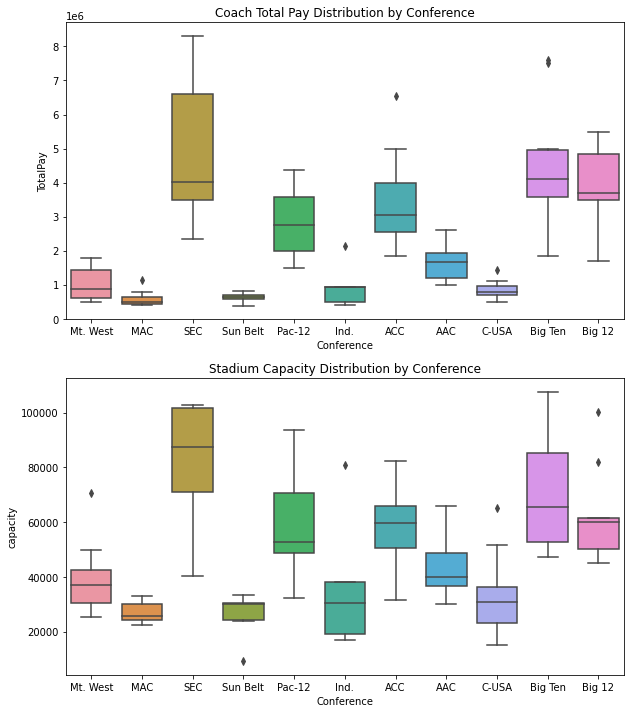

In [ ]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
sns.boxplot(x='Conference', y=yParm, data=df)
plt.title('Coach Total Pay Distribution by Conference')

plt.subplot(2,1,2)
sns.boxplot(x='Conference', y='capacity', data=df)
plt.title('Stadium Capacity Distribution by Conference')
plt.show()

Syracuse Belongs in the ACC, but if we look closely, there are only a few of conferences where their schools Total Paid to their coaches resembles the ACC's total distribution. Now, even if the Small Pay Conferences are not comparable to the AAC, we will still include them since they might have other information that might benefit the prediction. <br><br>
Another observation is that the stadium capacity seems to closely resemble the total pay, so it will be a strong factor to use in our model.

### Plot Capacity against Total Pay

Text(0.5, 1.0, 'Capacity vs Total Pay')

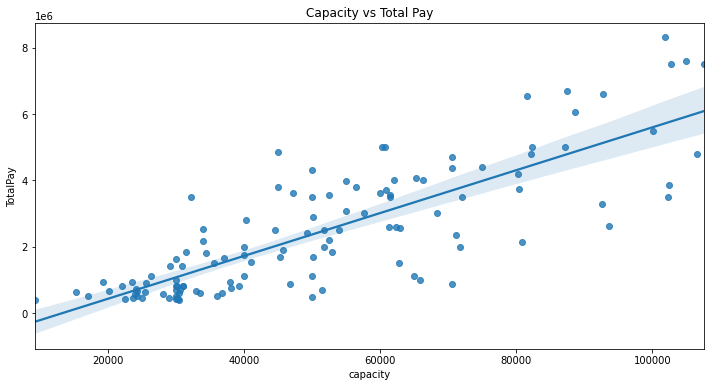

In [ ]:
plt.figure(figsize=(12,6))
sns.regplot(x='capacity', y=yParm, data=df)
plt.title('Capacity vs Total Pay')

## Check for Correlations

<Figure size 864x864 with 0 Axes>

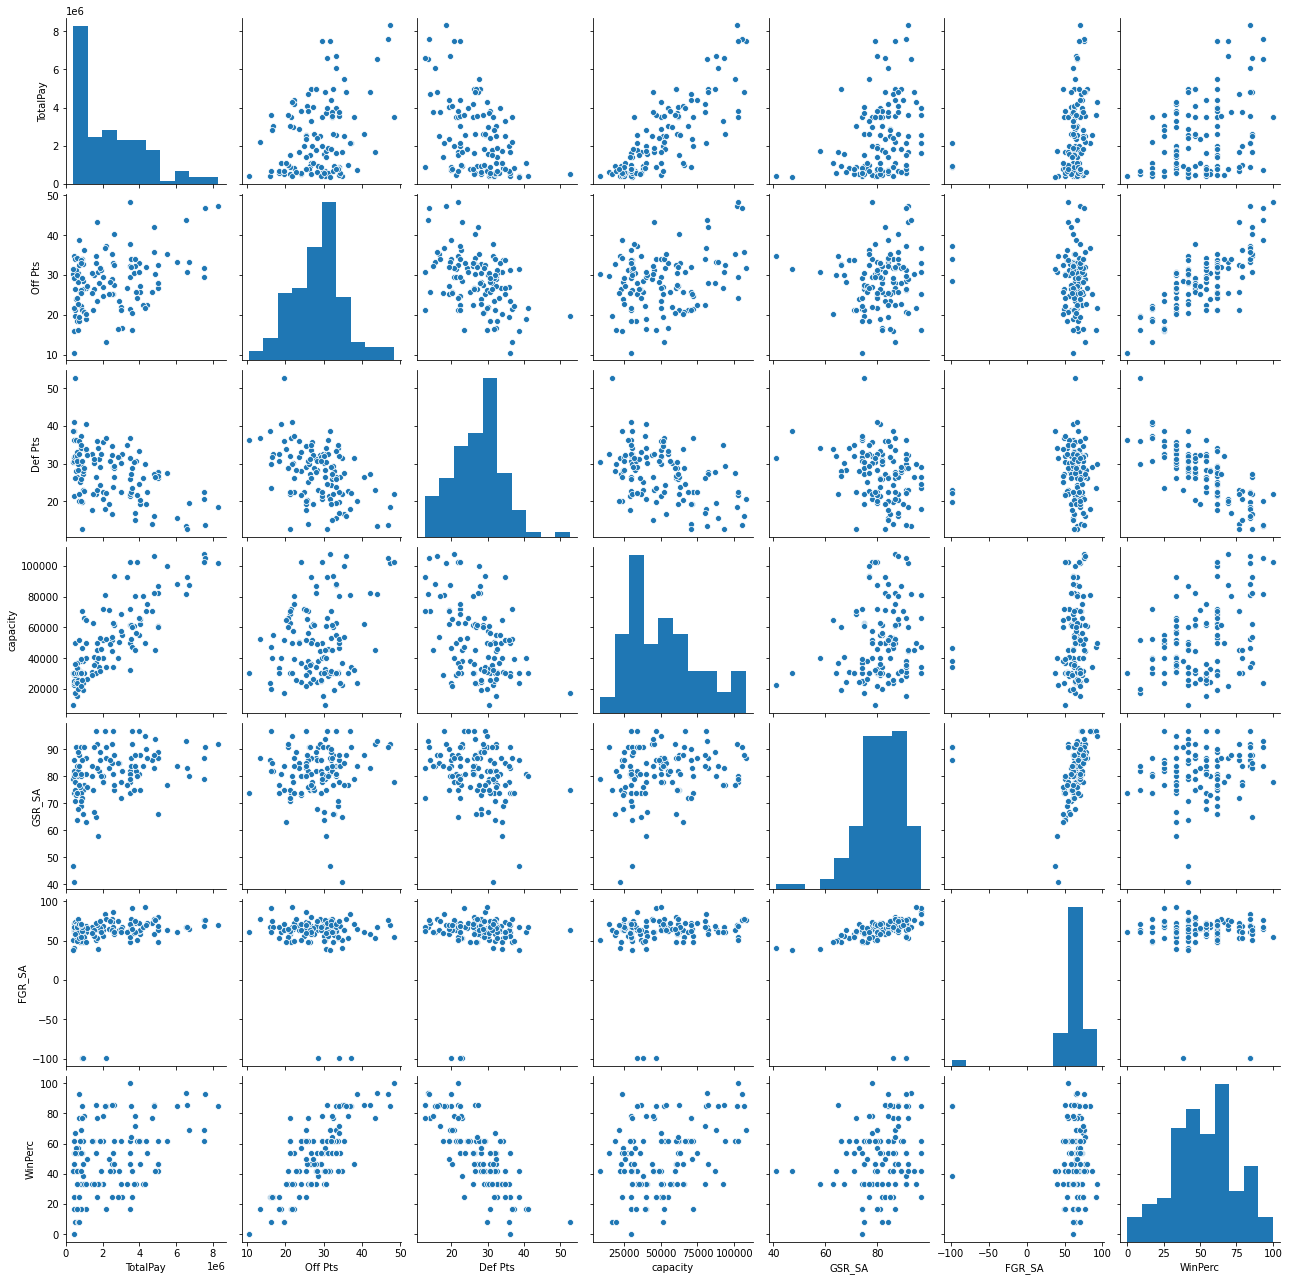

In [ ]:
plt.figure(figsize=(12,12))
numCols = ['TotalPay', 'Off Pts', 'Def Pts', 'capacity', 'GSR_SA', 'FGR_SA', 'WinPerc']
sns.pairplot(df[numCols])
plt.show()

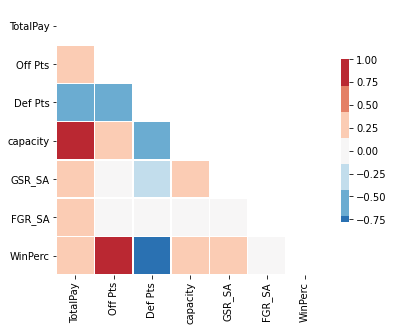

In [ ]:
plt.figure(figsize=(6,6))
numCols = ['TotalPay', 'Off Pts', 'Def Pts', 'capacity', 'GSR_SA', 'FGR_SA', 'WinPerc']

corr = df[numCols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("RdBu_r", 7)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Offensive Points has a strong positive correlation with Winning Percentage. Also, the Winning Percentage has a semi-strong positive correlation with Total Pay. On the other hand, FGR_SA (Federal Graduation Rate) seems to have no interesting distribution which can mean that there is no value of using it in the model. I will be excluding it from now on.

In [ ]:
df = df.drop(['FGR_SA'], axis=1) # Exclude Federal Graduation Rate for Student Athletes

### Check for Differences in Total Pay with Private vs Public Schools, Black vs Non-Black, and Top25 vs Not Top25

<Figure size 1296x432 with 0 Axes>

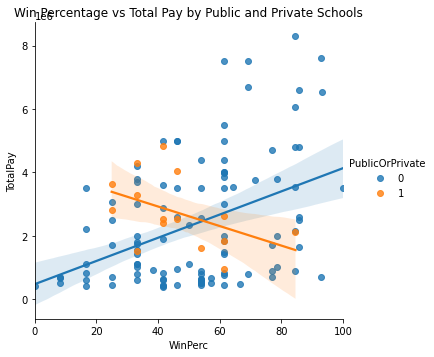

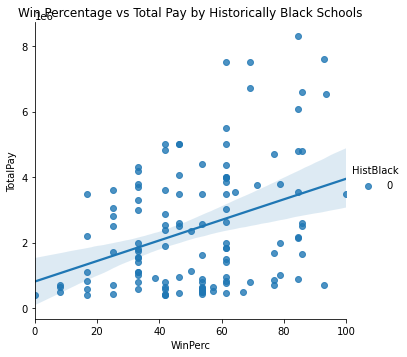

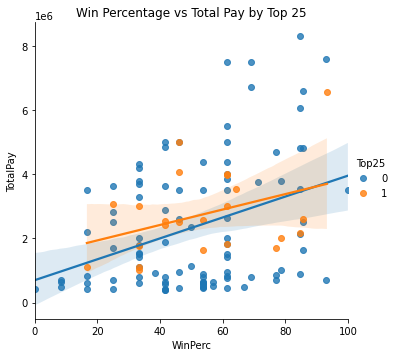

In [ ]:
fig = plt.figure(figsize=(18,6))
# plt.subplot(3,1,1)
sns.lmplot(x='WinPerc', hue='PublicOrPrivate', y=yParm, data=df)
fig.show()
plt.title('Win Percentage vs Total Pay by Public and Private Schools')
fig.show()
# plt.subplot(3,1,2)
sns.lmplot(x='WinPerc', hue='HistBlack', y=yParm, data=df)
plt.title('Win Percentage vs Total Pay by Historically Black Schools')
fig.show()
# plt.subplot(3,1,3)
sns.lmplot(x='WinPerc', hue='Top25', y=yParm, data=df)
plt.title('Win Percentage vs Total Pay by Top 25')
fig.show()

No definitive pattern in the above graph except that the higher the win percentage at a Public School, the higher the pay is for the coach. <br><br>
On the other hand, there is only Non-Historically black schools in the dataset, so we will drop the column from the analysis.<br><br>
No clear patter in Top25 schools either. We will keep the information for now, but will monitor the importance of the column in the model.

In [ ]:
df = df.drop(['HistBlack'], axis=1)

# Create Models

In [ ]:
df.head()

,School,Conference,Coach,TotalPay,FullName,Rk,W,L,Off Pts,Def Pts,capacity,GSR_SA,WinPerc,PublicOrPrivate,TotalPoints,Top25
0,Air Force,Mt. West,Troy Calhoun,885000.0,United States Air Force Academy,84.0,11.0,2.0,34.1,19.8,46692.0,86,84.6,0,53.9,0
1,Akron,MAC,Terry Bowden,412500.0,University of Akron Main Campus,76.0,0.0,12.0,10.5,36.3,30000.0,74,0.0,0,46.8,0
2,Alabama,SEC,Nick Saban,8307000.0,The University of Alabama,115.0,11.0,2.0,47.2,18.6,101821.0,92,84.6,0,65.8,0
3,Appalachian State,Sun Belt,Scott Satterfield,712500.0,Appalachian State University,121.0,13.0,1.0,38.8,20.0,24050.0,84,92.9,0,58.8,0
4,Arizona,Pac-12,Kevin Sumlin,2000000.0,University of Arizona,106.0,4.0,8.0,26.9,35.8,51811.0,78,33.3,0,62.7,0


# Need to Convert Categorical Columns to Binary Columns by Values

In [ ]:
conferencesL = df['Conference'].unique()
for conf in conferencesL:
    print(conf)
    df[conf] = [1 if conf == x else 0 for x in df['Conference'].values]

Mt. West
MAC
SEC
Sun Belt
Pac-12
Ind.
ACC
AAC
C-USA
Big Ten
Big 12


## Separate Into Train and Test Set
The Train and Test set need to be representative of the dataset, so I will be picking one team from each conference for the testing set in order to keep it constant. I will also exclude Syrcause from the training set to make sure I dont train on the value we are trying to predict.

In [ ]:
# Take out Syracuse from dataset. Leave out for testing
syr = df.loc[df['School'] == 'Syracuse'].reset_index(drop=True)
df = df.loc[df['School'] != 'Syracuse'].reset_index(drop=True)

In [ ]:
# Pick a Random Value from each Conference
size = 1        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
test = df.groupby('Conference', as_index=False).apply(fn).reset_index(drop=True)
train = df.loc[~(df['School'].isin(test['School'].values))].reset_index(drop=True)

In [ ]:
print('df len: ', len(df))
print('df train: ', len(train))
print('df test: ', len(test))

df len:  121
df train:  110
df test:  11


## Picking X Parameters for Model

### We can now select the X Parameters

Ranking, W and L are not relevant since we have the Win Percentage which is a better computational parameter. <br><br>
We can also drop the Conference column since we convereted it into binary columns for each conference used.

In [ ]:
df.columns

Index(['School', 'Conference', 'Coach', 'TotalPay', 'FullName', 'Rk', 'W', 'L',
       'Off Pts', 'Def Pts', 'capacity', 'GSR_SA', 'WinPerc',
       'PublicOrPrivate', 'TotalPoints', 'Top25', 'Mt. West', 'MAC', 'SEC',
       'Sun Belt', 'Pac-12', 'Ind.', 'ACC', 'AAC', 'C-USA', 'Big Ten',
       'Big 12'],
      dtype='object')

In [ ]:
xParm = ['TotalPoints', 'Top25', 'capacity', 'GSR_SA', 'WinPerc', 'W', 'L', 
       'PublicOrPrivate', 'SEC', 'Pac-12', 'ACC', 'AAC', 'Mt. West', 'MAC', 'SEC',
       'Sun Belt', 'Pac-12', 'Ind.', 'ACC', 'AAC', 'C-USA', 'Big Ten',
       'Big 12']

# We also create the list of parameters used in the OLS Model
xParmStr = 'Q("'+xParm[0]+'")'
for x in xParm[1:]:
    xParmStr += ' + ' + 'Q("'+x+'")'


In [ ]:
xParmStr

'Q("TotalPoints") + Q("Top25") + Q("capacity") + Q("GSR_SA") + Q("WinPerc") + Q("W") + Q("L") + Q("PublicOrPrivate") + Q("SEC") + Q("Pac-12") + Q("ACC") + Q("AAC") + Q("Mt. West") + Q("MAC") + Q("SEC") + Q("Sun Belt") + Q("Pac-12") + Q("Ind.") + Q("ACC") + Q("AAC") + Q("C-USA") + Q("Big Ten") + Q("Big 12")'

## Create Models

### OLS Model

In [ ]:
# specify a simple model with bobblehead entered last
my_model = str(yParm +  ' ~ ' + xParmStr)

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
train['TotalPayPred_OLS'] = train_model_fit.fittedvalues
# Get test values
test['TotalPayPred_OLS'] = train_model_fit.predict(test)

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     26.00
Date:                Thu, 23 Jul 2020   Prob (F-statistic):           3.25e-28
Time:                        18:02:26   Log-Likelihood:                -1647.5
No. Observations:                 110   AIC:                             3333.
Df Residuals:                      91   BIC:                             3384.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.111e+07 

## Decision Tree

In [ ]:
# Define the classifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


### Train Model

In [ ]:
parameters = {'max_depth':[5,10,15,20], 'max_features':[5,10,15,20, 30], 'max_leaf_nodes':[5,10,15]}

In [ ]:
dt = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=5, cv=5, verbose=10)

In [ ]:
dt = dt.fit(train[xParm].values, train[yParm].values)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1962s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0412s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0388s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  79 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0735s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 151 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1453s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Don

### Get the best DT Model out of the Grid Search

In [ ]:
dt_model = dt.best_estimator_
print (dt.best_score_, dt.best_params_) 

0.550612230764821 {'max_depth': 5, 'max_features': 15, 'max_leaf_nodes': 5}


In [ ]:
train['TotalPayPred_DT'] = dt_model.predict(train[xParm].values)
test['TotalPayPred_DT'] = dt_model.predict(test[xParm].values)

## Compare Models

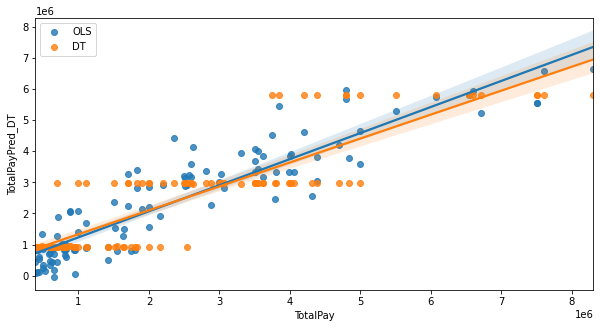

In [ ]:
## Training Set
fig,ax = plt.subplots(figsize=(10,5))
sns.regplot(x=yParm, y='TotalPayPred_OLS', data=train, ax=ax, label='OLS')
sns.regplot(x=yParm, y='TotalPayPred_DT', data=train, ax=ax, label='DT')
ax.legend()
fig.show()

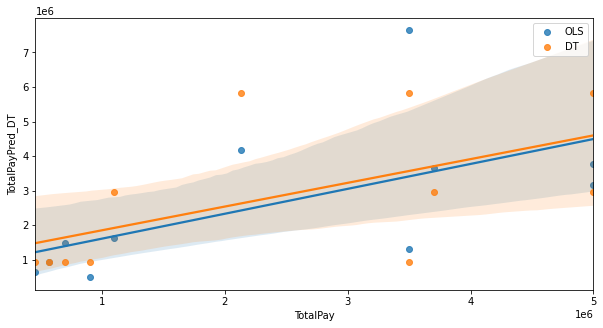

In [ ]:
## Test Set
fig,ax = plt.subplots(figsize=(10,5))
sns.regplot(x=yParm, y='TotalPayPred_OLS', data=test, ax=ax, label='OLS')
sns.regplot(x=yParm, y='TotalPayPred_DT', data=test, ax=ax, label='DT')
ax.legend()
fig.show()

Visually speaking, the OLS model is showing better results in the Test set. Now we will quantify the accuracy of the models using the Mean Square Difference.

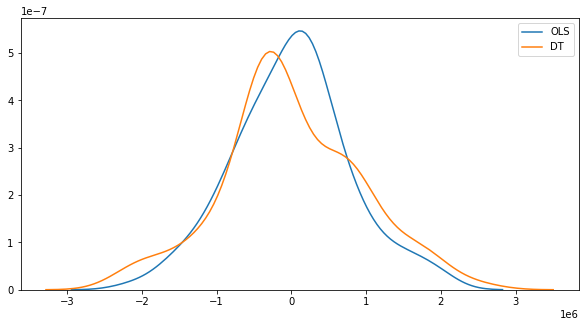

In [ ]:
## Train Set
train['DiffPred_OLS'] = train['TotalPay'] - train['TotalPayPred_OLS']
train['DiffPred_DT'] = train['TotalPay'] - train['TotalPayPred_DT']

fig,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(train['DiffPred_OLS'].values,ax=ax, label='OLS')
sns.kdeplot(train['DiffPred_DT'].values, ax=ax, label='DT')
ax.legend()
fig.show()

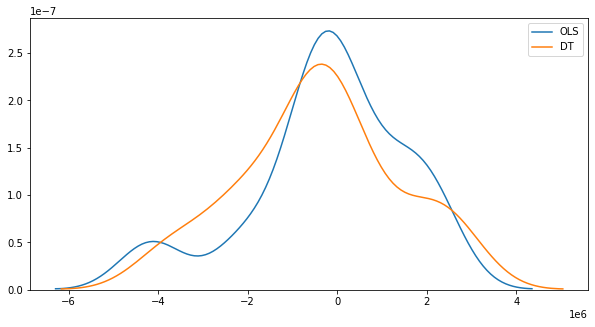

In [ ]:
## Test Set
test['DiffPred_OLS'] = test['TotalPay'] - test['TotalPayPred_OLS']
test['DiffPred_DT'] = test['TotalPay'] - test['TotalPayPred_DT']

fig,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(test['DiffPred_OLS'].values,ax=ax, label='OLS')
sns.kdeplot(test['DiffPred_DT'].values, ax=ax, label='DT')
ax.legend()
fig.show()

In [ ]:
print('Absolute Mean Difference Train OLS:', abs(train['DiffPred_OLS']).mean())
print('Absolute Mean Difference Train DT:', abs(train['DiffPred_DT']).mean())
print('Absolute Mean Difference Test OLS:', abs(test['DiffPred_OLS']).mean())
print('Absolute Mean Difference Test DT:', abs(test['DiffPred_DT']).mean())

Absolute Mean Difference Train OLS: 598523.4658410905
Absolute Mean Difference Train DT: 719152.2417134499
Absolute Mean Difference Test OLS: 1249012.5184749502
Absolute Mean Difference Test DT: 1375446.1882902058


## Conclusion on Model Decision

While the Decision Tree model has better results in the training dataset, the OLS model has much better results in the Test set. The OLS test absolute mean difference is 425638 while the DT test absolute mean difference is 885423 which is much larger. This could be an overfitting problem with the Decision Tree model. Therefore, we will move on with the OLS model as the Champion Model.

# Answer the Questions

## What is the predicted Pay for Syracuse Coach?

In [ ]:
syr['TotalPayPred'] = train_model_fit.predict(syr)

In [ ]:
syr

,School,Conference,Coach,TotalPay,FullName,Rk,W,L,Off Pts,Def Pts,capacity,GSR_SA,WinPerc,PublicOrPrivate,TotalPoints,Top25,Mt. West,MAC,SEC,Sun Belt,Pac-12,Ind.,ACC,AAC,C-USA,Big Ten,Big 12,TotalPayPred
0,Syracuse,ACC,Dino Babers,2401206.0,Syracuse University,6.0,5.0,7.0,28.3,30.7,49250.0,86,41.7,1,59.0,1,0,0,0,0,0,0,1,0,0,0,0,3.356648e+06


In [ ]:
3.356648e+06 - 2401206.0

955442.0

The prediction says that the Syracuse coach shoudl be making $ 3,356,648 which is almost a million more than he is. It is understandable since ACC coaches make a lot of money, but last year's record was terrible for this coach.

## What is the predicted pay for Syracuse Coach if we were in the Big East?
Trick question, since Big East schools went to AAC

In [ ]:
# Change ACC to Big East or AAC
syr['ACC'] = [0]
syr['AAC'] = [1]
syr.head()

,School,Conference,Coach,TotalPay,FullName,Rk,W,L,Off Pts,Def Pts,capacity,GSR_SA,WinPerc,PublicOrPrivate,TotalPoints,Top25,Mt. West,MAC,SEC,Sun Belt,Pac-12,Ind.,ACC,AAC,C-USA,Big Ten,Big 12,TotalPayPred
0,Syracuse,ACC,Dino Babers,2401206.0,Syracuse University,6.0,5.0,7.0,28.3,30.7,49250.0,86,41.7,1,59.0,1,0,0,0,0,0,0,0,1,0,0,0,3.356648e+06


In [ ]:
# test set predictions from the model fit to the training set
syr['TotalPayPred'] = train_model_fit.predict(syr)

In [ ]:
syr[['School', 'TotalPay', 'TotalPayPred']]

,School,TotalPay,TotalPayPred
0,Syracuse,2401206.0,1.957271e+06


In [ ]:
3.356648e+06 - 1.957271e+06

1399377.0

The pay for the coach would go down by $1,399,377.0

## What is the predicted pay for Syracuse Coach if we were in the Big Ten?

In [ ]:
# Change ACC to Big Ten
syr['AAC'] = [0]
syr['Big Ten'] = [1]
syr.head()

,School,Conference,Coach,TotalPay,FullName,Rk,W,L,Off Pts,Def Pts,capacity,GSR_SA,WinPerc,PublicOrPrivate,TotalPoints,Top25,Mt. West,MAC,SEC,Sun Belt,Pac-12,Ind.,ACC,AAC,C-USA,Big Ten,Big 12,TotalPayPred
0,Syracuse,ACC,Dino Babers,2401206.0,Syracuse University,6.0,5.0,7.0,28.3,30.7,49250.0,86,41.7,1,59.0,1,0,0,0,0,0,0,0,0,0,1,0,1.957271e+06


In [ ]:
# test set predictions from the model fit to the training set
syr['TotalPayPred'] = train_model_fit.predict(syr)

In [ ]:
syr[['School', 'TotalPay', 'TotalPayPred']]

,School,TotalPay,TotalPayPred
0,Syracuse,2401206.0,3.489457e+06


In [ ]:
3.356648e+06 - 3.489457e+06

-132809.0

If Syracuse went from the ACC to the Big Ten, the coach would get paid $123,809.0 more.

## What effect does Graduation Rate have on Coaches Pay?

In [ ]:
# To Check for this, we set all other variables to the a constant amount and test out different values
testdf = pd.DataFrame()
for gsr in [0,10,20, 30, 40,50,60, 70,80, 90, 100]:
  syr['GSR_SA'] = gsr
  testdf = pd.concat([testdf, syr])

print(testdf['GSR_SA'])

0      0
0     10
0     20
0     30
0     40
0     50
0     60
0     70
0     80
0     90
0    100
Name: GSR_SA, dtype: int64


In [ ]:
# Plug into model to see how the values change
testdf['TotalPayPred'] = train_model_fit.predict(testdf)

In [ ]:
# Look at how the GSR increases the predicted pay. 
print(testdf[['GSR_SA', 'TotalPayPred']])

   GSR_SA  TotalPayPred
0       0  1.905155e+06
0      10  2.089376e+06
0      20  2.273598e+06
0      30  2.457819e+06
0      40  2.642040e+06
0      50  2.826261e+06
0      60  3.010482e+06
0      70  3.194703e+06
0      80  3.378924e+06
0      90  3.563145e+06
0     100  3.747366e+06


In [ ]:
print(testdf['TotalPayPred'].diff())

0              NaN
0    184221.108892
0    184221.108892
0    184221.108892
0    184221.108892
0    184221.108892
0    184221.108892
0    184221.108892
0    184221.108892
0    184221.108892
0    184221.108892
Name: TotalPayPred, dtype: float64


According to the model output, the model goes up by $184,221 for every 10 percente increase in Graduation Rate.

## How good is our model?

In [ ]:
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     26.00
Date:                Thu, 23 Jul 2020   Prob (F-statistic):           3.25e-28
Time:                        18:07:56   Log-Likelihood:                -1647.5
No. Observations:                 110   AIC:                             3333.
Df Residuals:                      91   BIC:                             3384.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.111e+07 

The Adjusted R^2 value is equal to .805 which is a pretty strong correlation, and we are getting some interpretable results. The actual R^2 is about .837 which means that .837 of the Total Pay variation is explaning by the x paramters in the model. <br> <br>
Only three variables have P-values that don't go from positive to negative. This includes the variables: Big Ten, Big 12 and the Stadium Capacity. The P-value for the stadium capacity seems to be the most important out of the whole set of parameters since it has the smallest p-value. <br><br>
As show below, we can see that there is a big correlation between the predicted and actual total pay.

Text(0.5, 1.0, 'Predicted Total Pay vs Total Pay')

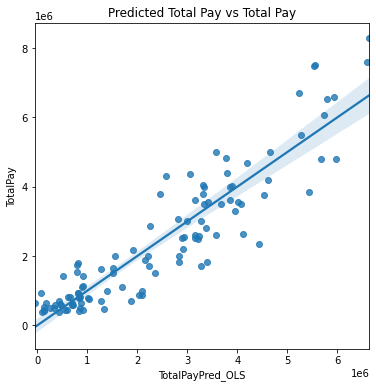

In [ ]:
plt.figure(figsize=(6,6))
sns.regplot(x='TotalPayPred_OLS', y=yParm, data=train)
plt.title('Predicted Total Pay vs Total Pay')

## What is the single biggest impact on salary size?

Text(0.5, 1.0, 'Stadium Capacity Distribution')

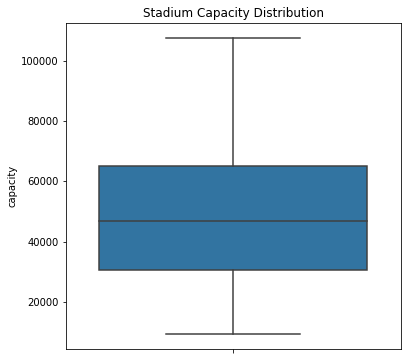

In [ ]:
plt.figure(figsize=(6,6))
sns.boxplot(y='capacity', data=train)
plt.title('Stadium Capacity Distribution')

The most important variable for the total pay of a coach is the stadium size. For every 1 extra fan, the coach gets an increase of 36.1871 dollars. To put this into perspective, the stadium capacity distribution ranges from about 30,000 fans to 110,000 fans. Therefore, if we increase the capacity by 10,000, the total pay increase by $360,000.

# Conclusion

The OLS model seems to be the best model so far. With a .83 R-squared value, the model is a strong prediction of the actual Total Pay. All in all, the Syracuse Coach is currently underpaid even if he had a terrible season.